# Interpolant transforms

notebook to visualise Nami's interpolant transform wrappers on simple 2D toy setup:

- `ScoreFromNoise`
- `DriftFromVelocityScore`
- `MirrorVelocityFromScore`

use a known score field so we can verify wrapper correctness numerically and visually.

In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn
import nami

torch.manual_seed(0)

## 1) Define toy fields

In [3]:
class ToyScore(nn.Module):
    @property
    def event_ndim(self) -> int:
        return 1
    def forward(self, x: torch.Tensor, t: torch.Tensor, c=None) -> torch.Tensor:
        _ = t, c
        # score for standard Gaussian up to constant: s(x) = -x
        return -x

class ToyVelocity(nn.Module):
    @property
    def event_ndim(self) -> int:
        return 1

    def forward(self, x: torch.Tensor, t: torch.Tensor, c=None) -> torch.Tensor:
        _ = t, c
        # weak rotational field
        vx = -0.35 * x[..., 1]
        vy = 0.35 * x[..., 0]
        return torch.stack([vx, vy], dim=-1)

class ToyEta(nn.Module):
    def __init__(self, score_model: nn.Module, gamma_schedule):
        super().__init__()
        self.score_model = score_model
        self.gamma_schedule = gamma_schedule

    @property
    def event_ndim(self) -> int | None:
        return getattr(self.score_model, "event_ndim", None)

    def forward(self, x: torch.Tensor, t: torch.Tensor, c=None) -> torch.Tensor:
        score = self.score_model(x, t, c)
        gamma = self.gamma_schedule.gamma(t).unsqueeze(-1)
        return gamma * score

### Build wrappers and sanity-check

In [4]:
gamma = nami.BrownianGamma()

score_true = ToyScore()
velocity = ToyVelocity()
eta = ToyEta(score_true, gamma)

score_from_noise = nami.ScoreFromNoise(eta, gamma, eps=1e-6)
drift_from_vs = nami.DriftFromVelocityScore(velocity, score_from_noise, gamma)
mirror_from_score = nami.MirrorVelocityFromScore(score_from_noise, gamma)

x = torch.randn(1024, 2)
t = torch.full((1024,), 0.35)

score_err = (score_from_noise(x, t) - score_true(x, t)).abs().max().item()

gg = gamma.gamma_gamma_dot(t).unsqueeze(-1)
drift_expected = velocity(x, t) + gg * score_true(x, t)
drift_err = (drift_from_vs(x, t) - drift_expected).abs().max().item()

mirror_expected = gg * score_true(x, t)
mirror_err = (mirror_from_score(x, t) - mirror_expected).abs().max().item()

print(f"max |score_from_noise - score_true| = {score_err:.3e}")
print(f"max |drift_from_vs - expected| = {drift_err:.3e}")
print(f"max |mirror_from_score - expected| = {mirror_err:.3e}")

max |score_from_noise - score_true| = 2.384e-07
max |drift_from_vs - expected| = 1.192e-07
max |mirror_from_score - expected| = 5.960e-08


### visualise vector fields at fixed time

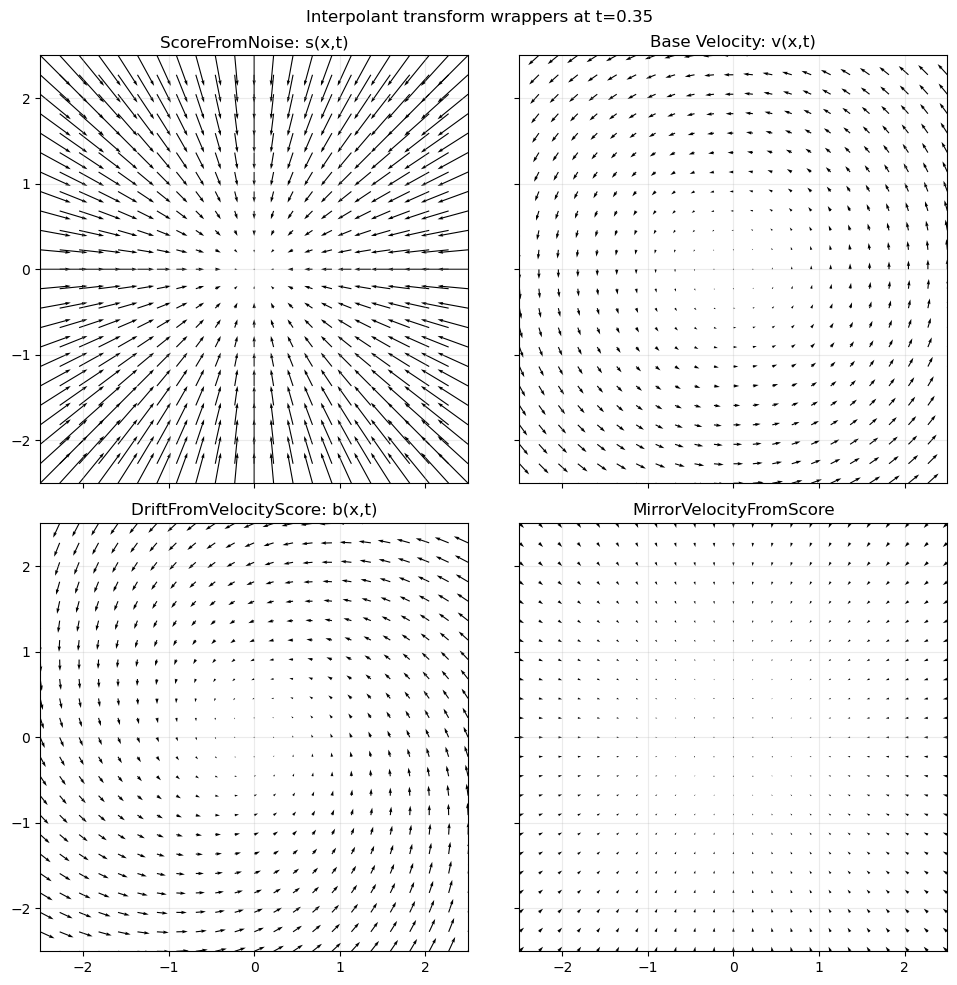

In [5]:
# Grid in R^2
n = 23
axis = torch.linspace(-2.5, 2.5, n)
X, Y = torch.meshgrid(axis, axis, indexing="xy")
points = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=-1)
t_plot = torch.full((points.shape[0],), 0.35)

S = score_from_noise(points, t_plot)
V = velocity(points, t_plot)
B = drift_from_vs(points, t_plot)
M = mirror_from_score(points, t_plot)

def split_uv(field: torch.Tensor):
    U = field[:, 0].reshape(n, n).detach().cpu()
    Vv = field[:, 1].reshape(n, n).detach().cpu()
    return U, Vv

Ux_s, Uy_s = split_uv(S)
Ux_v, Uy_v = split_uv(V)
Ux_b, Uy_b = split_uv(B)
Ux_m, Uy_m = split_uv(M)

fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
Xc = X.detach().cpu()
Yc = Y.detach().cpu()

axs[0, 0].quiver(Xc, Yc, Ux_s, Uy_s, angles="xy", scale_units="xy", scale=7)
axs[0, 0].set_title("ScoreFromNoise: s(x,t)")

axs[0, 1].quiver(Xc, Yc, Ux_v, Uy_v, angles="xy", scale_units="xy", scale=7)
axs[0, 1].set_title("Base Velocity: v(x,t)")

axs[1, 0].quiver(Xc, Yc, Ux_b, Uy_b, angles="xy", scale_units="xy", scale=7)
axs[1, 0].set_title("DriftFromVelocityScore: b(x,t)")

axs[1, 1].quiver(Xc, Yc, Ux_m, Uy_m, angles="xy", scale_units="xy", scale=7)
axs[1, 1].set_title("MirrorVelocityFromScore")

for ax in axs.ravel():
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-2.5, 2.5)
    ax.set_aspect("equal")
    ax.grid(alpha=0.25)

fig.suptitle("Interpolant transform wrappers at t=0.35")
plt.tight_layout()
plt.show()

For Brownian gamma, the scalar factor is

\(\gamma(t)\gamma'(t) = 0.5(1-2t)\).

So the mirror velocity `v_mirror = gamma(t)gamma_dot(t) * s` behaves as:

- `t < 0.5`: positive factor so mirror velocity aligns with score
- `t = 0.5`: factor is zero so mirror velocity vanishes
- `t > 0.5`: negative factor so mirror velocity flips direction

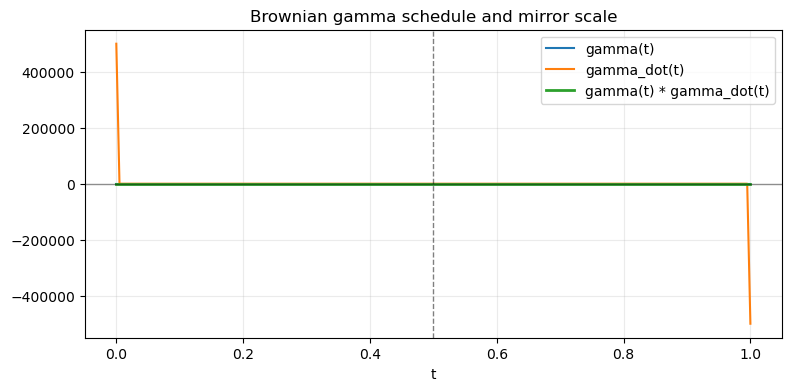

In [6]:
t_line = torch.linspace(0.0, 1.0, 200)
g = gamma.gamma(t_line)
gdot = gamma.gamma_dot(t_line)
gg = gamma.gamma_gamma_dot(t_line)

plt.figure(figsize=(9, 4))
plt.plot(t_line, g, label="gamma(t)")
plt.plot(t_line, gdot, label="gamma_dot(t)")
plt.plot(t_line, gg, label="gamma(t) * gamma_dot(t)", linewidth=2)
plt.axhline(0.0, color="black", linewidth=1, alpha=0.4)
plt.axvline(0.5, color="black", linestyle="--", linewidth=1, alpha=0.5)
plt.title("Brownian gamma schedule and mirror scale")
plt.xlabel("t")
plt.legend()
plt.grid(alpha=0.25)
plt.show()

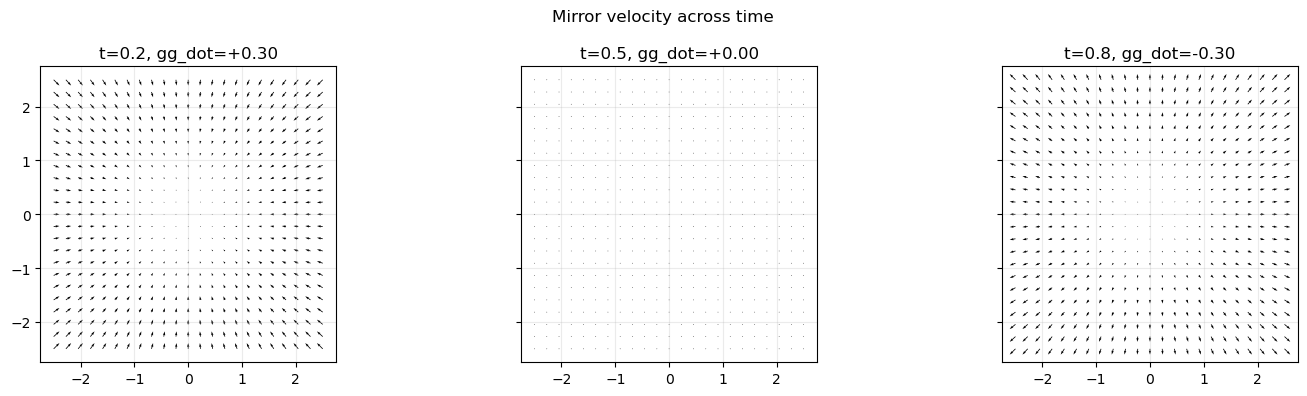

In [7]:
times = [0.2, 0.5, 0.8]
fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)

for ax, t0 in zip(axs, times):
    t_vec = torch.full((points.shape[0],), t0)
    M_t = mirror_from_score(points, t_vec)
    Ux_m, Uy_m = split_uv(M_t)
    scale = gamma.gamma_gamma_dot(torch.tensor([t0])).item()

    ax.quiver(Xc, Yc, Ux_m, Uy_m, angles="xy", scale_units="xy", scale=7)
    ax.set_title(f"t={t0:.1f}, gg_dot={scale:+.2f}")
    ax.set_aspect("equal")
    ax.grid(alpha=0.25)

plt.suptitle("Mirror velocity across time")
plt.tight_layout()
plt.show()